### Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import pandas as pd

%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

### A simple logistic birth + death process

#### Parameters

In [15]:
b = 3.068
d = 1.93
x0 = 0.5
N = 250.

#### Functions (in 1D)

$$d x = f(x)dt + \frac{1}{\sqrt{N}}g(x)dW$$

$$\frac{d \Xi}{dt} = 2 f'(x_{det}(t)) \Xi + [g(x_{det}(t))]^2$$

$$\Xi(t) = N \left\langle (x(t) - x_{det}(t))^2\right\rangle$$

The function `'path'` returns one realisation of the process

In [16]:
def f(x, b, d):
    return b*x*(1. - x) - d*x

def g(x, b, d):
    return max(b*x*(1. - x) + d*x, 0.)

def LNA(x, t, b, d, N):
    det, cov = x
    return np.array([f(det, b, d), 2.*cov*(b*(1.-2*det)-d) + g(det, b, d)])

def path(x, t, b, d, N):
    x_t = []
    for  time in t:
        x_t.append(x)
        y = f(x, b, d)*dt + np.sqrt(dt*g(x, b, d)/N)*np.random.normal()
        x += y 
    return np.array(x_t)

#### The 'real' process

In [17]:
dt = 0.001
t_full = np.arange(0., 35., dt)
x_real = path(x0, t_full, b, d, N)

#### Randomly sampled 'data'

In [18]:
measurements = np.sort(np.random.choice(range(len(t_full)), 100, replace=False))
artificial_timepoints = t_full[measurements]
artificial_data = x_real[measurements]

(array([ 0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55]),
 <a list of 8 Text yticklabel objects>)

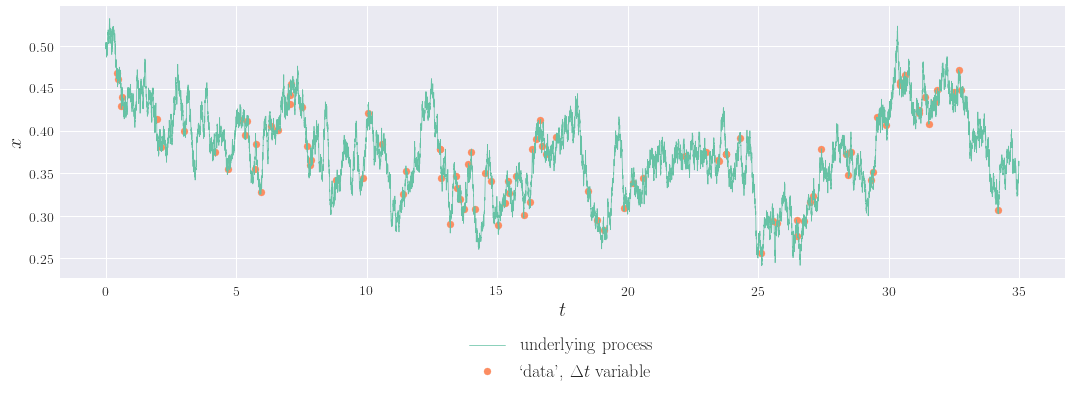

In [19]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real, linewidth=0.75, label=r"underlying process")
ax.scatter(artificial_timepoints, artificial_data, color=colours[1], label=r"`data', $\Delta t$ variable")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Zimmer's method

Given a set of parameter values:
- `'draw_next'` returns a reconstructed data point at time $t_{i+1}$ given the data at time $t_i$
- `'reconstruct'` returns the array of reconstructed data points
- `'likelihood_next'` returns the PDF of the approximation evaluated at the real data point at time $t_{i+1}$
- `'costfn'` returns the total cost function

In [20]:
def draw_next(data_now, data_next, time_now, time_next, b, d, N):
    t = np.linspace(time_now, time_next, 20)
    init_cond = np.array([data_now, 0])
    lna = odeint(LNA, init_cond, t, args=(b, d, N))[-1]
    mean = lna[0]
    std = np.sqrt(lna[1]/N)
    return np.random.normal(loc=mean, scale=std)

def reconstruct(params, data, times):
    b, d, N = params
    x_t = [data[0]]
    for i in range(len(data)-1):
        x_t.append(draw_next(data[i], data[i+1], times[i], times[i+1], b, d, N))
    return np.array(x_t)

def likelihood_next(data_now, data_next, time_now, time_next, b, d, N):
    t = np.linspace(time_now, time_next, 20)
    init_cond = np.array([data_now, 0])
    lna = odeint(LNA, init_cond, t, args=(b, d, N))[-1]
    mean = lna[0]
    std = np.sqrt(lna[1]/N)
    dist = norm(loc=mean, scale=std)
    return dist.pdf(data_next)

def costfn(params, *observations):
    data, times = observations
    b, d, N = params
    total = 0.
    for i in range(len(data)-1):
        total -= np.log(likelihood_next(data[i], data[i+1], times[i], times[i+1], b, d, N))
    return total

##### The estimation itself, using the differential evolution algorithm (algorithm choice arbitrary)

In [21]:
bounds = [(1., 5.), (1., 5.), (10., 1000.)]

observations = (artificial_data, artificial_timepoints)

estimation = differential_evolution(costfn, bounds, args=observations)
b_estim, d_estim, N_estim = estimation.x

/home/cparrar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


In [22]:
x_estim = reconstruct([b_estim, d_estim, N_estim], artificial_data, artificial_timepoints)

(array([ 0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55]),
 <a list of 8 Text yticklabel objects>)

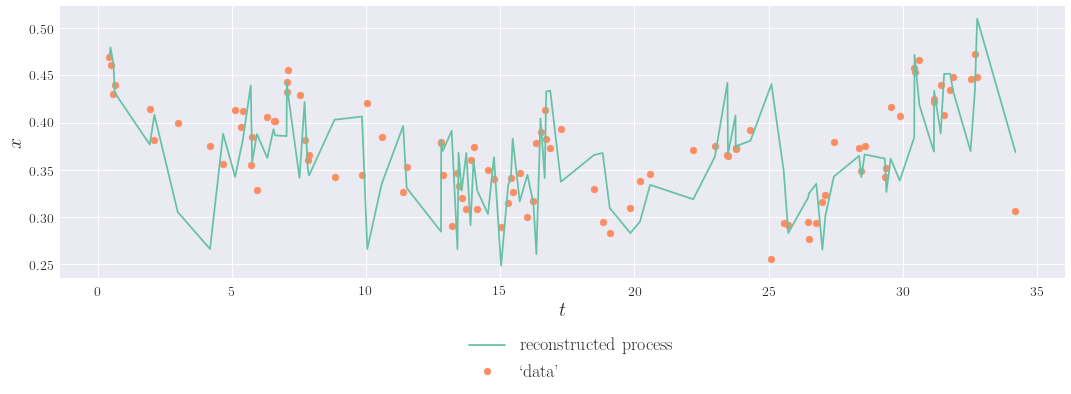

In [23]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(artificial_timepoints, x_estim, label=r"reconstructed process")
ax.scatter(artificial_timepoints, artificial_data, label=r"`data'", color=colours[1])
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18, loc=(0.4,-0.4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [24]:
init_cond = [x0, 0.]
x_real_det = odeint(LNA, init_cond, t_full, args=(b, d, N))[:, 0]
x_estim_det = odeint(LNA, init_cond, t_full, args=(b_estim, d_estim, N))[:, 0]

(array([ 0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52]),
 <a list of 9 Text yticklabel objects>)

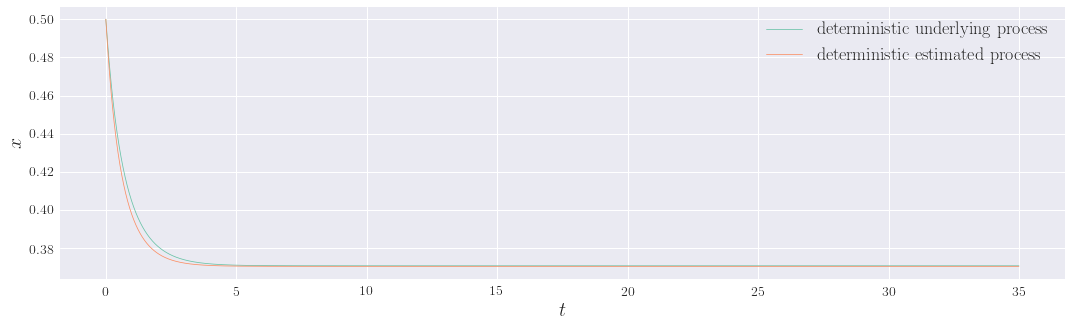

In [25]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real_det, linewidth=0.75, label=r"deterministic underlying process")
ax.plot(t_full, x_estim_det, linewidth=0.75, label=r"deterministic estimated process")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [26]:
params = {'process': ['real', 'estimated'], 'b': [b, b_estim], 'd': [d, d_estim], 'N': [N, N_estim]}
params = pd.DataFrame(params)
params.set_index(['process'])

,N,b,d
process,,,
real,250.000000,3.068000,1.930000
estimated,258.847184,3.617743,2.276842
